In [1]:
# Byzantine Generals, N consensus using Qiskit, OOP Approach

# Import statements
import itertools, matplotlib
import numpy as np
import matplotlib.pyplot as plt
import qiskit_aer.noise as ns
from decimal import Decimal
from scipy.special import comb
from qiskit.visualization import plot_histogram  # Visualizing stuff
from qiskit import QuantumCircuit, execute
from qiskit_aer import AerSimulator

#  Aesthetic Preferences
# matplotlib.use('tkagg')  # only use if QISKIT histogram is desired
np.set_printoptions(edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.3g" % x))



In [2]:
# Two-Threshold problem
# k = number of indices exchanged, N = number of generals, f = bitflip probability, cl = confidence level

def verify_threshold(N, k, f, cl):  # Lower bound on traitor failure rate
    t, sum = 0, 0.0
    while sum <= cl:
        sum += comb(k, t, exact=True) * ((2*f-1)**2 * (2/(3*N-3)) + 2*f*(1-f))**(t) * (1 - (2*f-1)**2 * (2/(3*N-3)) - 2*f*(1-f))**(k-t)
        t += 1
    return (t-1)/k  # Threshold as a rate

def B_lower(N, k, f, cl):  # Lower bound on traitor failure rate
    t, sum = 0, 0.0
    while sum <= 1 - cl:
        sum += comb(k, t, exact=True) * ((2*f-1)**2 * (2/(3*N-3)) + 2*f*(1-f))**(t) * (1 - (2*f-1)**2 * (2/(3*N-3)) - 2*f*(1-f))**(k-t)
        t += 1
    return (t-1)/k  # Threshold as a rate

def B_upper(N, k, f, cl):  # Upper bound on commander failure rate
    t, sum = 0, 0.0
    while sum <= cl:
        sum += comb(k, t, exact=True) * (2*f*(1-f))**(t) * (2*f**2 -2*f + 1)**(k-t)
        t += 1
    return (t-1)/k  # Threshold as a rate

# Estimating Cross Over points
def cross_over(N, k, f_step_size, cl):  # Should return the maximum f that B_lower is still greater than B_upper
    f = 0.0
    diff = B_lower(N, k, f, cl) - B_upper(N, k, f, cl)
    while diff >= 0.0:
        f += f_step_size
        diff = B_lower(N, k, f, cl) - B_upper(N, k, f, cl)
        if f >= 1.0:
            break
    return f - f_step_size

# Given a level error, what is the maximum confidence that can be obtained? Up to 3 d.p
def max_conf(N, k, f):
    """Parameter ranges without raising error:
    The more generals, the greater k is allowed to be!
    Low Error is easy to handle
    Min generals N=3 can handle k=3000//3, and f=0.49!
    """
    cl = 0.501
    diff = B_lower(N, k, f, cl) - B_upper(N, k, f, cl)
    while diff >= 0.001 and cl < 0.999:
        cl = round(cl + 0.001, 4)
        diff = round(B_lower(N, k, f, cl) - B_upper(N, k, f, cl), 3)
    return cl - 0.001



In [3]:
# Creating General Class for OOP Approach


class General():
    def __init__(self, general_number=1, is_commander=False):
        """
        An object that represents a single general, and tracks the associated attributes.
        id refers to their position in the list of generals.
        is_commander is a boolean that indicates whether the general is the commander, defaults to False.
        is_traitor is a boolean that indicates whether the general is a traitor, defaults to False.
        states 
        orders
        indices
        action
        """
        self.id = general_number
        self.is_commander = is_commander
        self.is_traitor = False
        self.states = None  # holds the measurement outcomes received
        self.orders = None  # holds the orders received from commander, or the opposite if general is a traitor
        self.indices = None  # holds the indices received from commander that correspond to self.orders
        self.action = None  # For a loyal general
        self.num_games = 0  # The number of pairwise games participated in
        self.comm_traitor_id = 0  # The number of times the commander has been detected as a traitor
    
    def __str__(self):
        # For user, only reveals attributes not None at initiation.
        return f"General Number:{self.id}, Is Commander:{self.is_commander}, Is Traitor:{self.is_traitor}\n"
        
    def __repr__(self):
        # For debugging, reveal all attributes, called when printing container of General objects e.g. generals_list
        return f"Num:{self.id}, Command:{self.is_commander}, Traitor:{self.is_traitor}, States:{self.states}, Orders:{self.orders}, Indices:{self.indices}, Action:{self.action} \n"
   
    def receive_orders(self, order, indices):
        self.orders = order
        self.indices = indices        
        if self.is_traitor and not self.is_commander:  # Only lieutenants traitor lietenants claim a different order
            self.indices = np.where(self.states == self.orders)[0][:len(self.indices)]  # Choosing the indices that will maximise deception success, but keeping the same number
            self.orders = not self.orders  # flipping the received order


class Byzantine_Network():
    def __init__(self, size):
        self.N_gen = size
        self.generals_list = []
        self.populate()
    
    def populate(self):
        if self.N_gen < 2:
            raise ValueError("Must have at least 2 generals in network.")
        self.generals_list.append(General(0, is_commander=True))
        for i in range(1,self.N_gen):
            self.generals_list.append(General(i, is_commander=False))


class Quantum_Source_Device():
    """
    This object represents the entanglement resource, it initializes and runs a quantum circuit. In theory the qubits should be distributed and measured by the generals.
    For the purposes of this model it is equivalent to measure centrally in this object and distribute measurement outcomes after.
    """
    def __init__(self, network_size, noise, noise_level):
        self.network_size = network_size  # Number of generals
        self.noise = noise
        self.noise_level = noise_level  # between 0 and 1.33
        self.backend = AerSimulator()  # The type of qiskit simulator to use
        if noise:
            # Depolarizing quantum errors
            noise_model = ns.NoiseModel()
            error = ns.pauli_error([('X', noise_level), ('I', 1 - noise_level)])  # Bitflip error
            noise_model.add_all_qubit_quantum_error(error, "measure")  # Error occurs at point of measurement
            self.backend = AerSimulator(noise_model=noise_model)
        self.initial_state = None
        self.prepare_initial_state()
        self.circuit = QuantumCircuit(self.network_size+1)  # arg: number of qubits
    
    def prepare_initial_state(self):
        # Preparing the initial state as numpy array, values are amplitudes, called during QSD initialization
        state = np.zeros(2**(self.network_size+1))
        state[2**(self.network_size-1)-1] = np.sqrt(1/3)  # Retreat order from commander
        state[2**(self.network_size) + 2**(self.network_size-1)] = np.sqrt(1/3)  # Attack order from commander
        for i in range(self.network_size-1):
            state[2**(self.network_size-1) + 2**i] = np.sqrt(1/(6*self.network_size-6))  # commander '01'
            state[2**(self.network_size) + 2**(self.network_size-1) - 1 - 2**i] = np.sqrt(1/(6*self.network_size-6))  # commander '10'
        self.initial_state = state
        
    def run_circuit(self, shots, visualize):
        self.circuit.initialize(self.initial_state, self.circuit.qubits)   # Initialize the qubits in the state to be distributed
        self.measurements = np.zeros((shots, self.network_size), dtype=int)  # Initializing array with a column for each general, and space to store the corresponding orders 0/1/2 retreat, attack, neither
        self.circuit.measure_active()  # Add a measurement of all qubits in the logical (0/1) basis
        # simulate the circuit
        job = execute(self.circuit, backend=self.backend, shots=shots, memory=True, optimization_level=2)
        memory = job.result().get_memory(self.circuit)  # recorded the strings of the measurement outcomes
        self.counts = job.result().get_counts(self.circuit)
        # Converting into Array of corresponding orders
        com_dic = {'00':0, '01':2, '10':2, '11':1}  # convert bitstrings to n_its and store them
        for i, bitstring in enumerate(memory):
            self.measurements[i][0] = com_dic[bitstring[0:2]] # Commander 2 indices
            for j in range(self.network_size-1):
                self.measurements[i][j+1] = int(bitstring[j+2])
        if visualize:
            hist = plot_histogram([self.counts])
            hist.show() 


class Quantum_Byzantine_Scheme():
    def __init__(self, size, shots, noise, noise_level, verbose, visualize):
        self.parameters = (size, shots, noise, noise_level, verbose, visualize)
        self.network = Byzantine_Network(size)
        self.qsd = Quantum_Source_Device(size, noise, noise_level)
        self.distribute_entanglement_resource(shots, visualize)

    def flip_allegiance(self, *general_number):
        for val in general_number:
            self.network.generals_list[val].is_traitor = not self.network.generals_list[val].is_traitor
    
    def distribute_entanglement_resource(self, shots, visualize):
        self.qsd.run_circuit(shots, visualize)
        for general in self.network.generals_list:
            general.states = self.qsd.measurements[:,general.id]

    def verify_entanglement(self):
        # Should not use for primary results. Really we are demonstrating given successful QKD.        
        if self.parameters[2]:  # Only runs if there is noise, otherwise automatic verification
            rounds = self.parameters[1]//3  # 33% sample for initial verification
            conf = max_conf(self.network.N_gen, rounds, self.qsd.noise_level)  # Always uses max confidence level possible
            threshold = verify_threshold(self.network.N_gen, rounds, self.qsd.noise_level, conf)
            pairs = list(itertools.combinations(self.network.generals_list[1:], 2))
            for pair in pairs:
                fails = 0  # Mutual exchange of values at random indices
                for r in range(rounds):
                    index = np.random.randint(self.parameters[1])
                    fails += int(pair[0].states[index] != pair[1].states[index])
                if fails/rounds > threshold:
                    for gen in pair:
                        if not gen.is_traitor:
                            gen.action = False  # If verification fails all loyal generals abort
                            if self.parameters[4]:
                                print(f"L{gen.id} abort due to state corruption")

    def send_orders(self, order_bool=None):
        """When the commander is loyal, a random order is first selected, corresponding indices are chosen and the lieutentants receive the same indices.
        When the commander is a traitor, under rational agent assumptions, to minimize consensus half of the lieutentants receive one order (correct) and half receive the other.
        Along with the corresponding indices. This is acheived by randomly reassigning order."""
        if order_bool is not None:
            order = order_bool
        else:
            order = bool(np.random.randint(2))  # random order to demonstrate symmetry
        if not self.network.generals_list[0].is_traitor:  # Loyal Commander Case
            indices = np.where(self.network.generals_list[0].states == order)[0]
            for gen in self.network.generals_list:
                gen.receive_orders(order, indices)
        else:
            l0, l1 = len(np.where(self.network.generals_list[0].states == 0)[0]), len(np.where(self.network.generals_list[0].states == 1)[0])  
            shorter_index_length = min(l0, l1)  # comparing lengths of indices to choose the shortest
            for gen in self.network.generals_list:  # Traitor Commander Case
                indices = np.where(self.network.generals_list[0].states == order)[0][0:shorter_index_length]
                gen.receive_orders(order, indices)
                order = not order  # half will get one order and half the other

    def detectable_broadcast(self):
        loyal_gens = [gen for gen in self.network.generals_list if not gen.is_traitor]
        tally = 0  # need to keep track of agreement
        db_achieved = False  # default false
        if not self.network.generals_list[0].is_traitor:  # If commander is loyal, all loyal generals agree on commanders action
            for gen in loyal_gens:
                tally += gen.action == self.network.generals_list[0].orders
        else:  # If commander is traitor, then all loyal generals agree on common action
            for gen in loyal_gens:
                tally += gen.action == loyal_gens[0].action
        if tally == len(loyal_gens):
            db_achieved = True
        return db_achieved

    def realize_agreement(self):
        rounds = len(self.network.generals_list[0].indices) # This should be ~33% of the shots, I'm not bothering to seperate the indices that are used vs unused
        conf = max_conf(self.network.N_gen, rounds, self.qsd.noise_level)  # Always uses max confidence level possible
        threshold = B_upper(self.network.N_gen, rounds, self.qsd.noise_level, conf)
        if self.parameters[4]:
            print(f"CL={conf}, Commander Traitor Rate <= {threshold}, L Traitor Rate > {B_lower(self.network.N_gen, rounds, self.qsd.noise_level, conf)}")
        def play(gen_pair):
            # Check if they agree on the order then initiate game if they do not
            if gen_pair[0].orders != gen_pair[1].orders:
                if not (gen_pair[0].is_traitor and gen_pair[1].is_traitor):  # Ignore cases with both traitors WLOG wrt DBA
                    failures = [0, 0]  # number of failures detected by general0 and general1
                    gen_pair[0].num_games += 1
                    gen_pair[1].num_games += 1
                    turn = bool(np.random.randint(2))  # random starting player
                    for i in range(rounds):  # Exchanging indices 1 at a time
                        if gen_pair[int(turn)].states[gen_pair[int(not turn)].indices[i]] != gen_pair[int(turn)].orders:
                            failures[int(turn)] += 1
                        if gen_pair[int(not turn)].states[gen_pair[int(turn)].indices[i]] != gen_pair[int(not turn)].orders:
                            failures[int(not turn)] += 1
                        turn = not turn
                    
                    failures = [failures[0]/rounds, failures[1]/rounds]  # converting to rate
                    if not gen_pair[0].is_traitor:
                        if failures[0] > threshold:
                            if self.parameters[4]:
                                print(f"L{gen_pair[0].id} identifies L{gen_pair[1].id} as a traitor, failure rate {failures[0]}.")
                        else:
                            if self.parameters[4]:
                                print(f"L{gen_pair[0].id} plays L{gen_pair[1].id}, identifies Commander traitor, failure rate {failures[0]}.")
                            gen_pair[0].comm_traitor_id += 1

                    if not gen_pair[1].is_traitor:
                        if failures[1] > threshold:
                            if self.parameters[4]:
                                print(f"L{gen_pair[1].id} identifies L{gen_pair[0].id} as a traitor, failure rate {failures[1]}.")
                        else:
                            if self.parameters[4]:
                                print(f"L{gen_pair[1].id} plays L{gen_pair[0].id}, identifies Commander traitor, failure rate {failures[1]}.")
                            gen_pair[1].comm_traitor_id += 1       
        pairs = list(itertools.combinations(self.network.generals_list[1:], 2))
        for pair in pairs:
            play(pair)
        # Locking in actions
        for gen in self.network.generals_list:
            if gen.comm_traitor_id > 0:
                gen.action = False
            else:
                gen.action = gen.orders
 


def run_protocol(number_of_generals, number_of_traitors, shots=2096, noise=False, noise_level=0.0, verify=False, verbose=False, visualize=False):
    traitors = np.random.choice(number_of_generals, number_of_traitors, replace=False)
    qbs = Quantum_Byzantine_Scheme(number_of_generals, shots, noise, noise_level, verbose, visualize)
    if verify:
        qbs.verify_entanglement()
    qbs.flip_allegiance(*traitors)
    qbs.send_orders()
    qbs.realize_agreement()
    return qbs.detectable_broadcast()




In [ ]:

# Building Table to hold results
# columns: Num generals, Num traitors, Noise Levels, Success Prob as cell values
players = []
for gen_num in range(3, 10):
    for trait_num in range(1, gen_num):
        players.append([gen_num, trait_num])
players = np.array(players)

nl_vals = np.arange(0.00, 0.50, 0.01)
results = np.zeros((players.shape[0], 2+nl_vals.shape[0]))
results[:,0:2] = players

print(f"Max i: {players.shape[0]}")
for i in range(results.shape[0]):
    print(i)
    for j in range(nl_vals.shape[0]):
        for k in range(100):
            results[i,j+2] += run_protocol(int(results[i,0]), int(results[i,1]), shots=2096, noise=True, noise_level=nl_vals[j], verify=False, verbose=False, visualize=False)

results

np.save('results_no_EM.np', results)

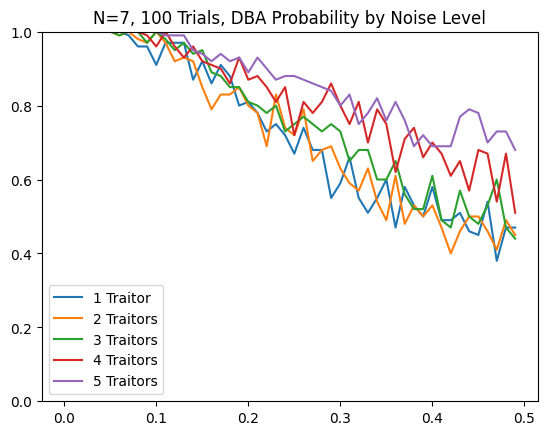

In [26]:
plt.plot(nl_vals, results[14,2:]/100, label="1 Traitor")
plt.plot(nl_vals, results[15,2:]/100, label="2 Traitors")
plt.plot(nl_vals, results[16,2:]/100, label="3 Traitors")
plt.plot(nl_vals, results[17,2:]/100, label="4 Traitors")
plt.plot(nl_vals, results[18,2:]/100, label="5 Traitors")
plt.title("N=7, 100 Trials, DBA Probability by Noise Level")
plt.ylim(0,1.0)
plt.legend()
plt.show()

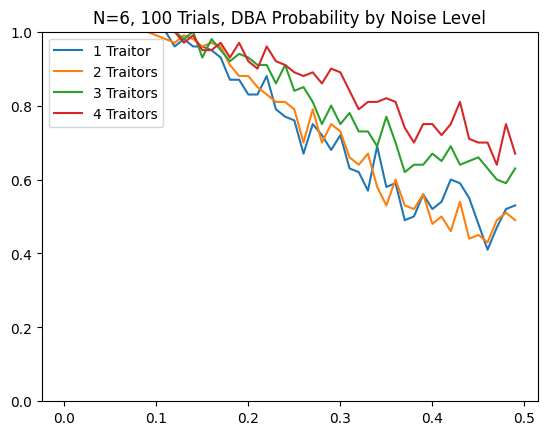

In [25]:
plt.plot(nl_vals, results[9,2:]/100, label="1 Traitor")
plt.plot(nl_vals, results[10,2:]/100, label="2 Traitors")
plt.plot(nl_vals, results[11,2:]/100, label="3 Traitors")
plt.plot(nl_vals, results[12,2:]/100, label="4 Traitors")
plt.title("N=6, 100 Trials, DBA Probability by Noise Level")
plt.ylim(0,1.0)
plt.legend()
plt.show()

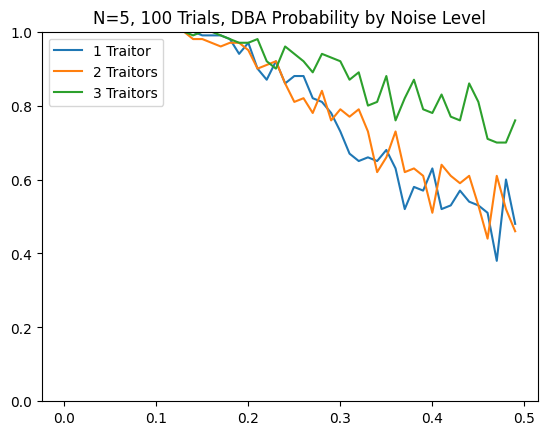

In [24]:
plt.plot(nl_vals, results[5,2:]/100, label="1 Traitor")
plt.plot(nl_vals, results[6,2:]/100, label="2 Traitors")
plt.plot(nl_vals, results[7,2:]/100, label="3 Traitors")
plt.title("N=5, 100 Trials, DBA Probability by Noise Level")
plt.ylim(0,1.0)
plt.legend()
plt.show()

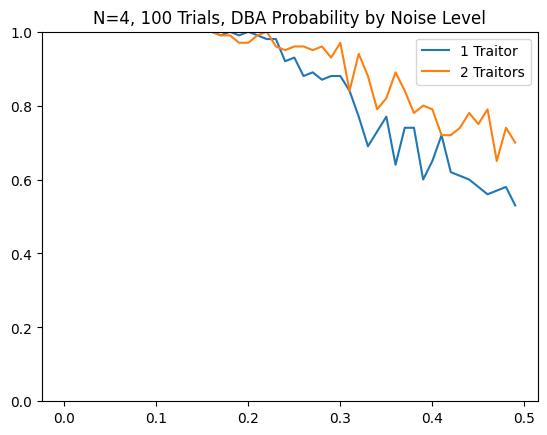

In [22]:

plt.plot(nl_vals, results[2,2:]/100, label="1 Traitor")
plt.plot(nl_vals, results[3,2:]/100, label="2 Traitors")
plt.title("N=4, 100 Trials, DBA Probability by Noise Level")
plt.ylim(0,1.0)
plt.legend()
plt.show()

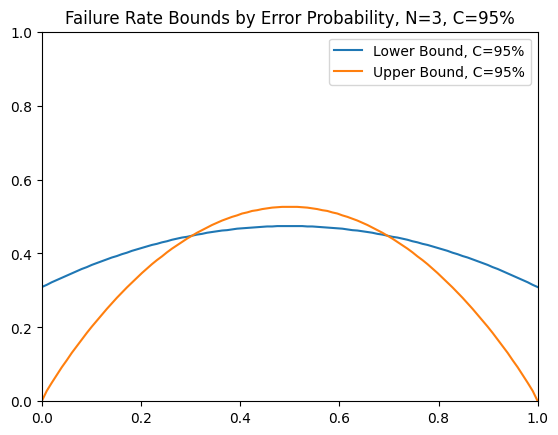

In [26]:
k_size = 1000  # The number of indices exchanged
f_vec = np.linspace(0.0, 1.0, 100)  # bit flip error rates

lower_vec, upper_vec = np.zeros(100), np.zeros(100)
for i in range(len(f_vec)):
    lower_vec[i] = B_lower(3, k_size, f_vec[i], 0.95)
    upper_vec[i] = B_upper(3, k_size, f_vec[i], 0.95)

plt.plot(f_vec, lower_vec, label="Lower Bound, C=95%")
plt.plot(f_vec, upper_vec, label="Upper Bound, C=95%")
plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)
plt.legend()
plt.title("Failure Rate Bounds by Error Probability, N=3, C=95%")
plt.show()

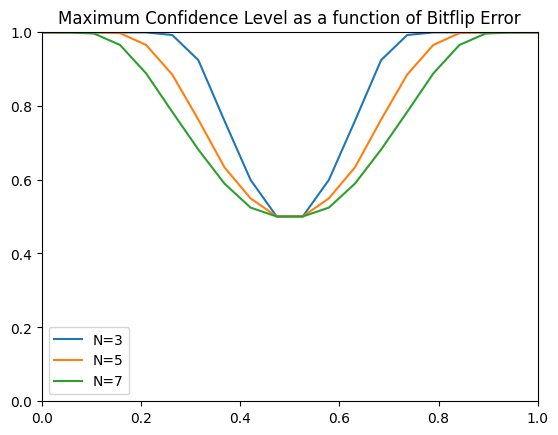

In [40]:
# Maximum confidence level as a function of the amount of error

k_size = 1000  # The number of indices exchanged
f_vec = np.linspace(0.0, 1.0, 20)  # bit flip error rates
conf_max_vec = np.zeros((3,20))

for i in range(conf_max_vec.shape[1]):
    conf_max_vec[0,i] = max_conf(3, k_size, f_vec[i])
    conf_max_vec[1,i] = max_conf(5, k_size, f_vec[i])
    conf_max_vec[2,i] = max_conf(7, k_size, f_vec[i])

plt.plot(f_vec, conf_max_vec[0], label="N=3")
plt.plot(f_vec, conf_max_vec[1], label="N=5")
plt.plot(f_vec, conf_max_vec[2], label="N=7")

plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)
plt.legend()
plt.title("Maximum Confidence Level as a function of Bitflip Error")
plt.show()


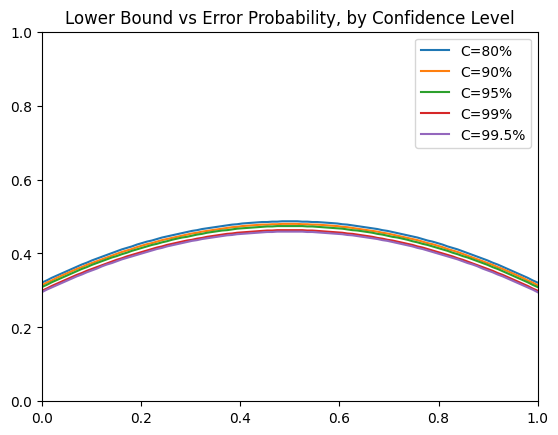

In [41]:
k_size = 1000  # The number of indices exchanged
f_vec = np.linspace(0.0, 1.0, 100)  # bit flip error rates

# Demonstrating the effect of confidence level, Lower bound
lower_80, lower_90, lower_95, lower_99, lower_995 = np.zeros(100), np.zeros(100), np.zeros(100), np.zeros(100), np.zeros(100)
for i in range(len(f_vec)):
    lower_80[i] = B_lower(3, k_size, f_vec[i], 0.80)
    lower_90[i] = B_lower(3, k_size, f_vec[i], 0.90)
    lower_95[i] = B_lower(3, k_size, f_vec[i], 0.95)
    lower_99[i] = B_lower(3, k_size, f_vec[i], 0.99)
    lower_995[i] = B_lower(3, k_size, f_vec[i], 0.995)

plt.plot(f_vec, lower_80, label="C=80%")
plt.plot(f_vec, lower_90, label="C=90%")
plt.plot(f_vec, lower_95, label="C=95%")
plt.plot(f_vec, lower_99, label="C=99%")
plt.plot(f_vec, lower_995, label="C=99.5%")
plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)
plt.legend()
plt.title("Lower Bound vs Error Probability, by Confidence Level")
plt.show()


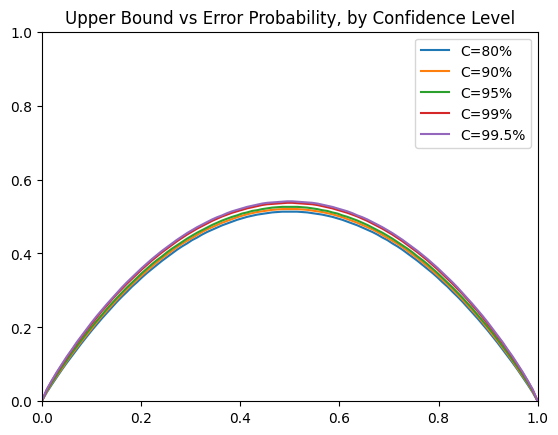

In [43]:
k_size = 1000  # The number of indices exchanged
f_vec = np.linspace(0.0, 1.0, 100)  # bit flip error rates

# Demonstrating the effect of confidence level, Upper bound
upper_80, upper_90, upper_95, upper_99, upper_995 = np.zeros(100), np.zeros(100), np.zeros(100), np.zeros(100), np.zeros(100)
for i in range(len(f_vec)):
    upper_80[i] = B_upper(3, k_size, f_vec[i], 0.80)
    upper_90[i] = B_upper(3, k_size, f_vec[i], 0.90)
    upper_95[i] = B_upper(3, k_size, f_vec[i], 0.95)
    upper_99[i] = B_upper(3, k_size, f_vec[i], 0.99)
    upper_995[i] = B_upper(3, k_size, f_vec[i], 0.995)

plt.plot(f_vec, upper_80, label="C=80%")
plt.plot(f_vec, upper_90, label="C=90%")
plt.plot(f_vec, upper_95, label="C=95%")
plt.plot(f_vec, upper_99, label="C=99%")
plt.plot(f_vec, upper_995, label="C=99.5%")
plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)
plt.legend()
plt.title("Upper Bound vs Error Probability, by Confidence Level")
plt.show()

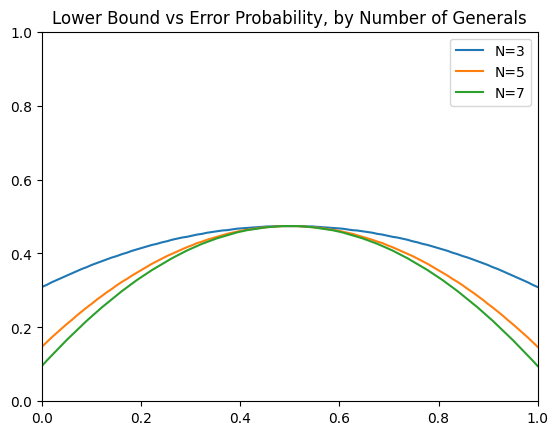

In [44]:
k_size = 1000  # The number of indices exchanged
f_vec = np.linspace(0.0, 1.0, 100)  # bit flip error rates

# Demonstrating the effect of Number of Generals
lower_3, lower_5, lower_7 = np.zeros(100), np.zeros(100), np.zeros(100)
for i in range(len(f_vec)):
    lower_3[i] = B_lower(3, k_size, f_vec[i], 0.95)
    lower_5[i] = B_lower(5, k_size, f_vec[i], 0.95)
    lower_7[i] = B_lower(7, k_size, f_vec[i], 0.95)

plt.plot(f_vec, lower_3, label="N=3")
plt.plot(f_vec, lower_5, label="N=5")
plt.plot(f_vec, lower_7, label="N=7")
plt.ylim(0.0, 1.0)
plt.xlim(0.0, 1.0)
plt.legend()
plt.title("Lower Bound vs Error Probability, by Number of Generals")
plt.show()

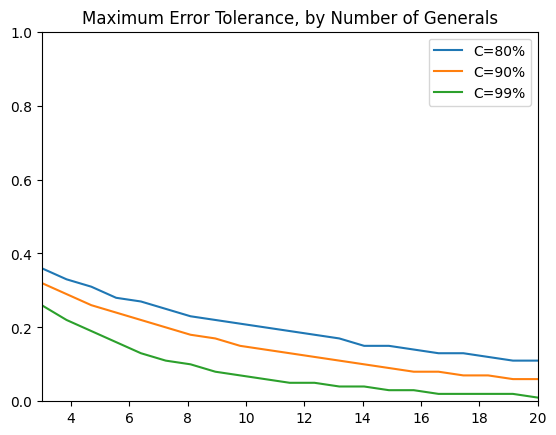

In [46]:
k_size = 1000  # The number of indices exchanged

# Maximum tolerate bitflip probability by number of generals for different N
gen_nums = np.linspace(3, 20, 21)
max_tolerance_80 = np.zeros(len(gen_nums))
max_tolerance_90 = np.zeros(len(gen_nums))
max_tolerance_99 = np.zeros(len(gen_nums))

for i in range(len(gen_nums)):
    max_tolerance_80[i] = cross_over(gen_nums[i], k_size, 0.01, 0.80)
    max_tolerance_90[i] = cross_over(gen_nums[i], k_size, 0.01, 0.90)
    max_tolerance_99[i] = cross_over(gen_nums[i], k_size, 0.01, 0.99)


plt.plot(gen_nums, max_tolerance_80, label="C=80%")
plt.plot(gen_nums, max_tolerance_90, label="C=90%")
plt.plot(gen_nums, max_tolerance_99, label="C=99%")
plt.ylim(0.0, 1.0)
plt.xlim(3, gen_nums[-1])
plt.legend()
plt.title("Maximum Error Tolerance, by Number of Generals")
plt.show()

